# Sliding Window Pipeline

Here we will apply trained vehicle-vs-non_vehicle SVM classifier in a sliding window fashion to detect vehicles in the scene.

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

%matplotlib inline

# load my utils
from imp import reload
import utils_hog
reload(utils_hog); from utils_hog import *

## Configurable Variables

In [2]:
slide_window_shape = 96
stride = 48

# artifacts folder
GEN_FOLDER = './gen'
if not os.path.exists(GEN_FOLDER):
    os.makedirs(GEN_FOLDER)

## Load pretrained classifiers

In [3]:
from sklearn.externals import joblib

# load svm classifiers
svm_clf = joblib.load(GEN_FOLDER + '/vehicle_vs_non_vehicle_model.pkl') 
svm_pca = joblib.load(GEN_FOLDER + '/vehicle_vs_non_vehicle_pca.pkl') 

print(svm_clf, '\n')
print(svm_pca, '\n')

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) 



## Apply Model Predictions

In [4]:
# wrapper: predict whether there is a vehicle in the given image patch
def find_vehicle(img_trunc):
    pca_features = extract_features_and_apply_pca2(img_trunc, 64, 64, svm_pca)
    
    is_vehicle = svm_clf.predict(pca_features)[0]
    prediction_probabilities = svm_clf.predict_proba(pca_features)[0]    
    return is_vehicle

# Sliding window

In [5]:
def apply_sliding_window(image):

    start = time.time()
    image_copy = np.copy(image)
    img_size = np.shape(image)

    # compute number of sliding windows in x & y direction
    nx_windows = np.floor((img_size[1] - slide_window_shape) / stride) + 1
    ny_windows = np.floor((img_size[0] - slide_window_shape) / stride) + 1

    # start sliding
    for i_y in range(np.int(ny_windows)):
        for i_x in range(np.int(nx_windows)):
            
            img_trunc = img[i_y*stride : i_y*stride + slide_window_shape, 
                            i_x*stride : i_x*stride + slide_window_shape]

            # feed truncated image to classifier
            found_vehicle = find_vehicle(img_trunc)
            
            if found_vehicle == 1:
                cv2.rectangle(image_copy, 
                              (i_x*stride, i_y*stride), 
                              (i_x*stride + slide_window_shape, i_y*stride + slide_window_shape), 
                              (255,0,0), 3)
                
    end = time.time()
    # print("Time taken:", (end-start))
    return image_copy

## Apply sliding window

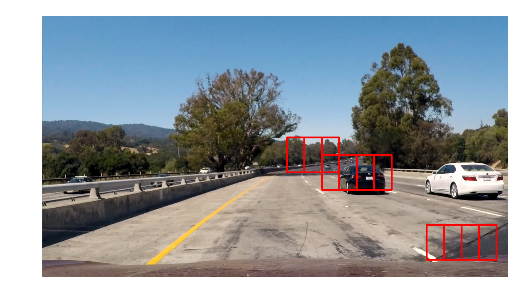

In [6]:
# load sample image
test_fn = 'test_images/test1.jpg'

img = mpimg.imread(test_fn)
#img = cv2.resize(img,(960,540))
#img = img/255.

processed_image = apply_sliding_window(img)

plt.imshow(processed_image)
plt.axis('off')
plt.show()

## Process Video

In [7]:
from moviepy.video.io.VideoFileClip import VideoFileClip

input_video = 'p4_project_video.mp4'
input_video = 'p4_challenge_video.mp4'
output_video = input_video[:-4] + '_processed.mp4'

video_clip = VideoFileClip(input_video)
processed_clip = video_clip.fl_image(apply_sliding_window)

# save video
processed_clip.write_videofile(output_video, audio=False)  
print('Done')

[MoviePy] >>>> Building video p4_challenge_video_processed.mp4
[MoviePy] Writing video p4_challenge_video_processed.mp4


100%|██████████| 485/485 [16:03<00:00,  1.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p4_challenge_video_processed.mp4 

Done


## Visualize movie

In [9]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))